## 1.0 Loading Libraries & Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
from dataclasses import dataclass
import os
from typing import Union, List, Optional
plt.style.use('ggplot')

In [2]:
!unzip '/content/Indian_stocks.zip' -d '/content'

Archive:  /content/Indian_stocks.zip
   creating: /content/Indian_stocks/
  inflating: /content/Indian_stocks/ADANIPORTS.csv  
  inflating: /content/Indian_stocks/ASIANPAINT.csv  
  inflating: /content/Indian_stocks/AXISBANK.csv  
  inflating: /content/Indian_stocks/BAJAJ-AUTO.csv  
  inflating: /content/Indian_stocks/BAJAJFINSV.csv  
  inflating: /content/Indian_stocks/BAJFINANCE.csv  
  inflating: /content/Indian_stocks/BHARTIARTL.csv  
  inflating: /content/Indian_stocks/BPCL.csv  
  inflating: /content/Indian_stocks/BRITANNIA.csv  
  inflating: /content/Indian_stocks/CIPLA.csv  
  inflating: /content/Indian_stocks/COALINDIA.csv  
  inflating: /content/Indian_stocks/DRREDDY.csv  
  inflating: /content/Indian_stocks/EICHERMOT.csv  
  inflating: /content/Indian_stocks/GAIL.csv  
  inflating: /content/Indian_stocks/GRASIM.csv  
  inflating: /content/Indian_stocks/HCLTECH.csv  
  inflating: /content/Indian_stocks/HDFC.csv  
  inflating: /content/Indian_stocks/HDFCBANK.csv  
  inflating:

### 1.0 CSV files Loading

In [3]:
class CSVLoader:
    """Simple Wrapper for loading all csv files from a folder."""
    def __init__(self, filepath:str, feature:Union[List[str], str], split:float = 0.9)->None:
        """

        Args:
            filepath (str): path to folder containing csv files
            feature (Union[List[str], str]): Target feature
            split (float, optional): Number of csv files from folder to be used for training. Defaults to 0.9. Use 1.0 if test folder is seperate.
        """
        self.feature = feature
        self.split = split
        self.get_file_paths(filepath)

    def get_file_paths(self, filepath:str):
        """Get path of all csv files in folder."""
        self.file_paths = []
        for root, dirs, folder in os.walk(filepath):
            for file in folder:
                if file.endswith('.csv'):
                    self.file_paths.append(os.path.join(root, file))

    def get_data_from_csv_files(self)->List[np.ndarray]:
        """Extracts data from all csv files using Pandas.

        Returns:
            List[np.ndarray]: List of data for in the form of numpy array for each file. *Concatenation* is *avoided* to enable processing on file basis,
            such as differencing.
        """
        total = []
        for path in self.file_paths[:int(len(self.file_paths) * self.split)]:
            df = pd.read_csv(path)
            data = df[self.feature].to_numpy(np.float64)
            total.append(data)
        return total

loader = CSVLoader(r'/content/Indian_stocks', ['Close'], split=0.9)
data = loader.get_data_from_csv_files()
print(
    f'Total Files : {len(loader.file_paths)}',
    f'\nFiles used for training : {len(loader.file_paths[:int(len(loader.file_paths) * loader.split)])}'
    )

Total Files : 51 
Files used for training : 45


**Why not concatenate entire data from all csv files?**
- Any kind of processing like differencing makes more sense to applied per file basis.
- For instance applying differencing to entire data may lead to abrupt changes at file boundaries. Assuming two consecutive files have data with positive trend, differencing may lead to a sudden negative value leading to unneccessary outliers.

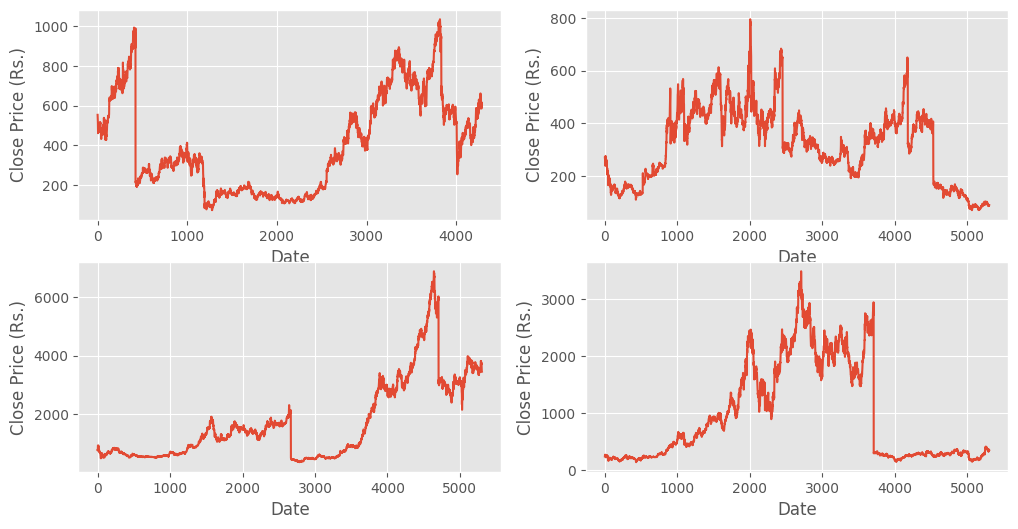

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    ax.plot(data[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price (Rs.)')
plt.show();

## 2.0 Building Intuition for developing Preprocessing Pipeline.

Before we develop a preprocessing pipleline, we try to build our intuition behind doing so.
It is easier to train a model on stationary data so we perform preprocessing to make data stationary, that is remove trend and seasonality.  <br><br>
We want to ensure that our data appears to be sampled from white noise at the end of preprocessing.
<br> The intuition behind this is that we can have algorithms to artificially create seasonality and trend, but cannot do so for the random data obtained after processing. The model is trained to find patterns that we cannot find in this random data.
<br><br>
Steps involved:
<ol>
  <li>Detrending</li>
  <li>Dealing with Outliers</li>
  <li>Tokenization</li>
</ol>

### 2.1 Detrending

##### 2.1.1 First Difference


First Differencing:
$$y_{t+1} = x_{t+1} - x_{t}$$

<b>Advantages</b>:
<ul>
    <li>It removes trend from data in most scenarios.</li>
</ul><br>
<b>Disadvantages</b>:
<ul>
    <li>There is high <b>variance</b> in the data.</li>
    <li>Data does not have <b>universal trend</b>. </li>
</ul>

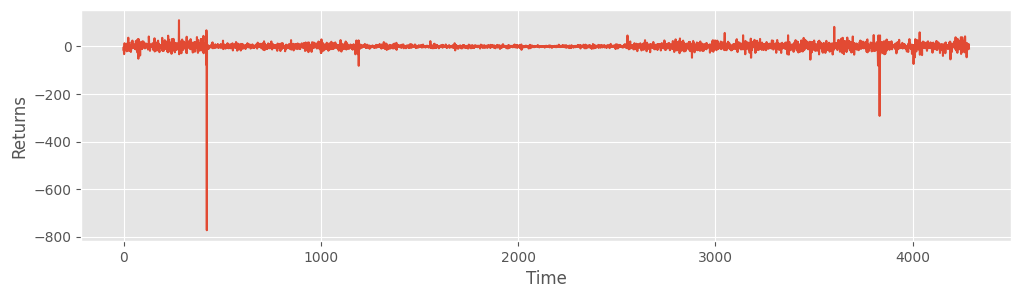

In [5]:
plt.figure(figsize=(12, 3))
plt.plot(np.diff(data[0], n=1, axis=0))
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show();

##### 2.1.2 Log Returns

Log Returns :
$$z_t = ln(1 + r_t) =ln(\frac{p_{t+1}}{p_t})\\[1em]
where\; r_t = \frac{(p_{t+1} - p_t)}{p_t}
$$
<br><br>Advantages:
- Reduces Variance.
- Log returns have no bounds i.e $ln(r_t + 1) \in (-\infty,\infty)$


<ipython-input-6-b1c9e4d4823e>:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x+1), label= 'f(x) = log(1+x)')


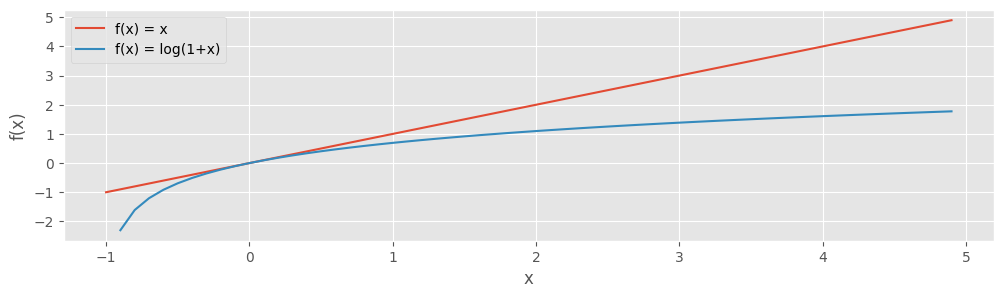

In [6]:
def compare_normal_log():
    plt.figure(figsize=(12,3))
    x = np.arange(-1, 5, 0.1)
    plt.plot(x, x, label='f(x) = x')
    plt.plot(x, np.log(x+1), label= 'f(x) = log(1+x)')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.show()

compare_normal_log()

Log function suppresses big positive values while emphasizing small negative values, log returns are more symmetric than returns.

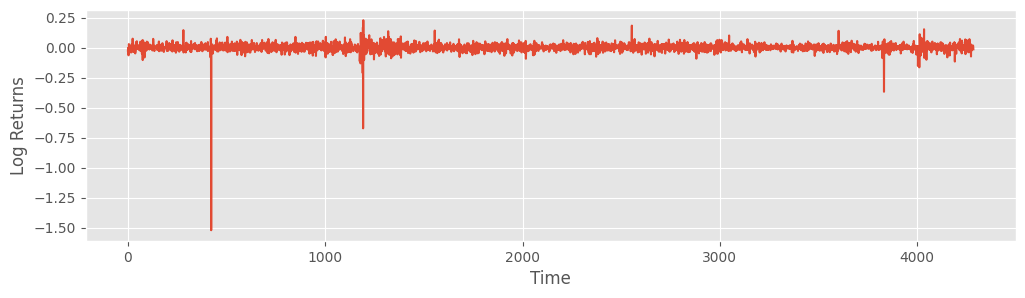

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(np.diff(np.log(data[0]), n=1, axis=0))
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.show();

### 2.2 Dealing with outliers

`Need for outlier removal:`
- Since we will later process this data through a min-max scaler, outliers will make the minima and maxima of the data to be high causing the data to be squeezed to smaller range
- In practise, beyond the theoretical reasoning, if the outliers were not removed the tokenizer did not perform as expected, as the scaler skewed data towards 0 or 1 depending on min and max bounds of orignal data.

In [8]:
temp = np.diff(np.log(data[0]), n=1, axis=0)
print(f'Minimmum : {np.min(temp)}')
print(f'Maximum : {np.max(temp)}')
print(f'Mean : {np.mean(temp)}')
print(f'Standard Deviation : {np.std(temp)}')

Minimmum : -1.5219295489413227
Maximum : 0.22798103346324883
Mean : 2.136267431286695e-05
Standard Deviation : 0.036787890380435936


<h3><u><a href = "https://en.wikipedia.org/wiki/Standard_score">Z-Score / Standard Score</u></h3>

The standard score is the number of standard deviations by which the value of a raw score (i.e., an observed value or data point) is above or below the mean value of what is being observed or measured.<br>
$$ Z_{score} = \frac {x - x_{mean}}{x_{std} + ϵ}$$

In [9]:
def reject_outliers(data, percentile):
    z_score = abs(data - np.mean(data, axis=0)) / np.std(data, axis=0)
    data = data[np.where(z_score < np.percentile(z_score, percentile))]
    return data

Loss of data after removing outliers: 0.5365 %


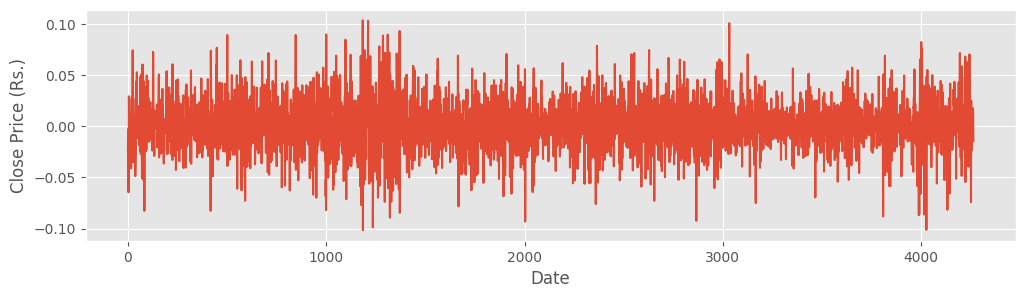

In [10]:
temp = reject_outliers(temp, 99.5)
print(f'Loss of data after removing outliers: {(len(data[0])-len(temp))*100/len(data[0]):.4f} %')
plt.figure(figsize=(12, 3))
plt.xlabel('Date')
plt.ylabel('Close Price (Rs.)')
plt.plot(temp)
plt.show();

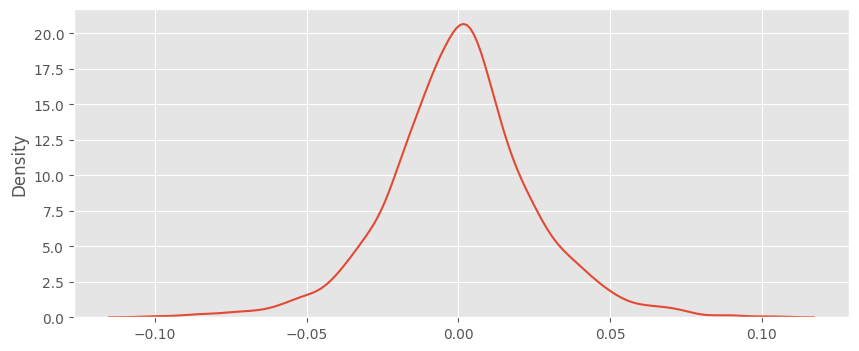

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.kdeplot(temp)
plt.show();

### 2.3 Tokenization

The point of tokenization is to convert this continuous data into discrete classes which can be mapped into n-unique tokens and fed to an embedding layer. <br><br>
For a simplistic approach we just use a min-max scaler to map our data to a vocab range and than round the scaled outputs:<br>
$ X \in [-∞,∞] \to MinMax(X) \in[0,\;vocab\;size]$, and the range is continuous with native precision (float32 or float64).<br><br>
Than we apply rounding to convert to integers to make data discrete with only vocab size classes

In [12]:
class Tokenizer:
    """Simple Tokenizer Implementation"""
    def __init__(self, vocab_size:int)->None:
        self.vocab_size = vocab_size
        # To account for 0 indexing
        self.new_max = vocab_size - 1
        self.new_min = 0.0

    def fit(self, data:np.ndarray):
        """Calculates data min and max."""
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)

    def _check_if_fitted(self):
        if not hasattr(self, 'min') and not hasattr(self, 'max'):
            raise Exception('Tokenizer has not been fit on the data')

    def transform(self, data:np.ndarray)->np.ndarray:
        self._check_if_fitted()

        data = (data - self.min) / (self.max - self.min) * (self.new_max - self.new_min) + self.new_min
        # passing as long here ensures that later when converted to float32 precision
        # there is no chance of going outside our embedding classes
        return np.round(data).astype(np.longlong)

    def fit_transform(self, data:np.ndarray) -> np.ndarray:
        self._check_if_fitted()

        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, data:np.ndarray) -> np.ndarray:
        self._check_if_fitted()
        return (data - self.new_min) / (self.new_max - self.new_min) * (self.max - self.min) + self.min

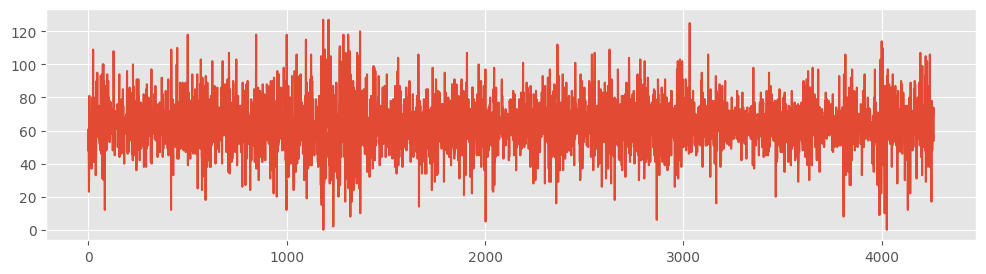

In [13]:
scaler = Tokenizer(128)
scaler.fit(temp)
sc_temp = scaler.transform(temp)

plt.figure(figsize=(12, 3))
plt.plot(sc_temp)
plt.show();

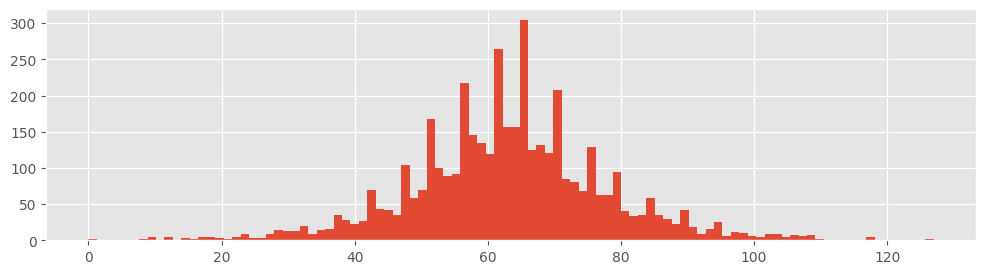

In [14]:
plt.figure(figsize=(12,3))
plt.hist(sc_temp, bins=100)
plt.show()

### 2.4 Putting it all together

In [15]:
class Preprocessor:
    def __init__(self, vocab_size:int, drop_p:float):
        """Single class for transforming or inverse transforming data in and out from our model.

        Args:
            vocab_size (int): size of vocab
            drop_p (float): percentile of outliers to be dropped. $$\in[0,100]$$
        """
        self.tokenizer = Tokenizer(vocab_size)
        self.drop_p = drop_p

    def reject_outliers(self, data:np.ndarray, percentile:float) -> np.ndarray:
        """Removes outliers based on z-score method. Instead of using threshold to match percentile of
            data under normal distribution, direct threshold is used since orignal data and z-score
            values have same size.

        Args:
            data (np.ndarray):
            percentile (float):

        Returns:
            np.ndarray: _description_
        """
        z_score = abs(data - np.mean(data, axis=0)) / np.std(data, axis=0)
        data = data[np.where(z_score < np.percentile(z_score, percentile))]
        return data

    def detrend(self, data:np.ndarray) -> np.ndarray:
        """Detrend csv files. If list of data from files is provided detrending is done on each file indivually.
            Uses log returns to detrend.
        Args:
            data (np.ndarray): data with trend.

        Returns:
            np.ndarray: data without trend.
        """

        if type(data) == list:
            detrended = []
            for i in data:
                detrended.append(
                    np.diff(np.log(i), axis=0)
                )
            detrended = np.concatenate(detrended, axis=0)
        elif type(data) == np.ndarray:
            detrended = np.diff(np.log(data), axis=0)
        return detrended

    def fit(self, data:np.ndarray)->np.ndarray:
        """Steps involved:
            - Trend Removal
            - Outliers Removal
            - Fitting Min-Max Scaler to compute minumum and maximum
        Args:
            data (np.ndarray): data with no preprocessing applied.

        Returns:
           np.ndarray: This fit model returns as it carries out detrending and outlier removal.
        """
        detrended = self.detrend(data)
        detrended = np.concatenate(detrended, axis=0)
        detrended = self.reject_outliers(detrended, self.drop_p)
        self.tokenizer.fit(detrended)
        return detrended

    def transform(self, data:np.ndarray) -> np.ndarray:
        """Tokenizes input data"""
        token_ids = self.tokenizer.transform(data)
        return token_ids

    def inverse_transform(self, token_ids:np.ndarray, initial:np.ndarray) -> np.ndarray:
        """Steps involved:
            1. Detokenizing model outputs
            2. Retrend the data.

        Args:
            token_ids (np.ndarray):
            initial (np.ndarray): Usually last value of unprocessed version of input.
                                Necessary to have right level when carrying out cumsum.
                                Otherwise, data will be shifted below if initial is zero.

        Returns:
            np.ndarray: _description_
        """
        unscaled_data = self.tokenizer.inverse_transform(np.array(token_ids))
        unscaled_data = np.insert(unscaled_data, 0, np.log(initial))
        unscaled_data = np.cumsum(unscaled_data, axis=0)
        trended_data = np.exp(unscaled_data)
        return trended_data

preprocessor = Preprocessor(vocab_size=256, drop_p=99.5)
temp = preprocessor.fit(data)
token_ids = preprocessor.transform(temp)
print(f'Number of token_ids : {len(token_ids)}')

Number of token_ids : 440654


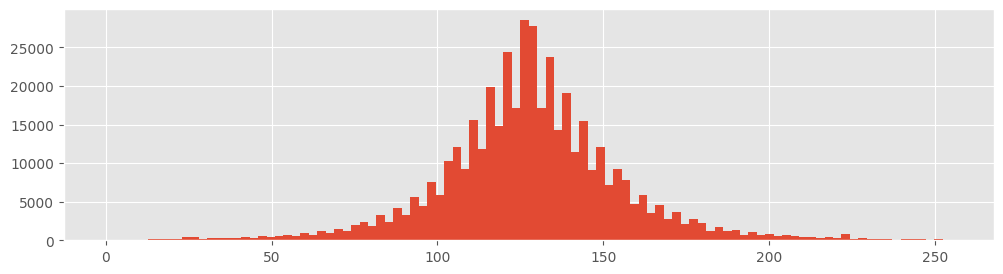

In [16]:
plt.figure(figsize=(12,3))
plt.hist(token_ids, bins=100)
plt.show()

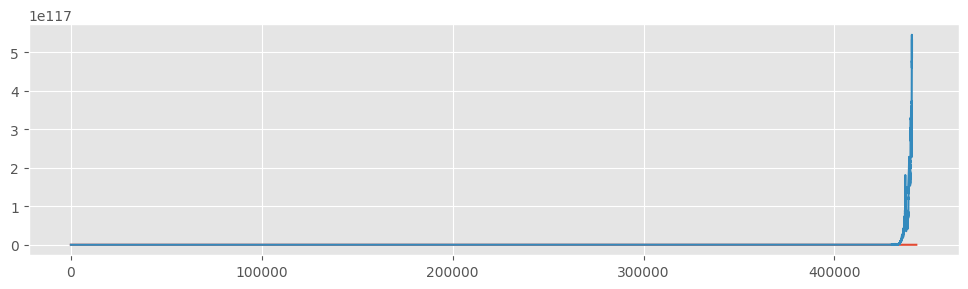

In [17]:
plt.figure(figsize=(12,3))
plt.plot(np.concatenate(data, axis=0))
plt.plot(preprocessor.inverse_transform(token_ids, data[0][0]))
plt.show();

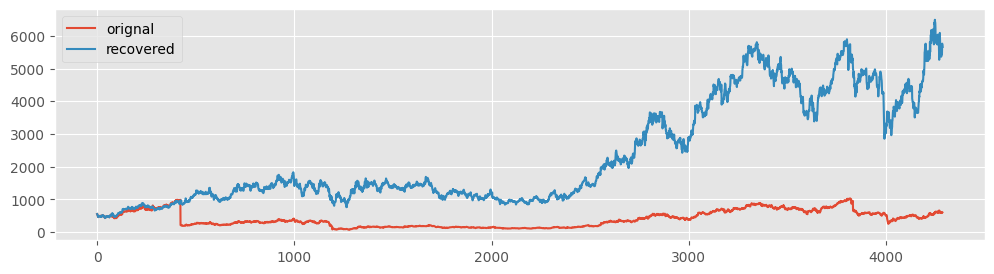

In [18]:
temp = preprocessor.inverse_transform(token_ids[:len(data[0])], data[0][0])
plt.figure(figsize=(12,3))
plt.plot(data[0], label='orignal')
plt.plot(temp, label='recovered')
plt.legend()
plt.show();

## 3.0 Custom Pytorch Dataset

In [19]:
class CSVDataset(Dataset):
    def __init__(self, data:np.ndarray, seq_len:int, preprocessor:Preprocessor)->None:
        super().__init__()
        self.data = data
        self.seq_len = seq_len
        self.preprocessor = preprocessor
        self.data = self.preprocessor.fit(data)

    def __len__(self)->int:
        return self.data.shape[0] - self.seq_len

    def __getitem__(self, index:int) -> tuple[torch.Tensor, torch.Tensor]:
        data = self.data[index : index + self.seq_len + 1]
        data = self.preprocessor.transform(data)
        return torch.tensor(data[:-1], dtype=torch.long), torch.tensor(data[1:], dtype=torch.long)

dataset = CSVDataset(data, 32, preprocessor)
print(f'Length of Dataset : {len(dataset)}\nShape of x: {dataset[0][0].shape}\nShape of y: {dataset[0][1].shape}')

Length of Dataset : 440622
Shape of x: torch.Size([32])
Shape of y: torch.Size([32])


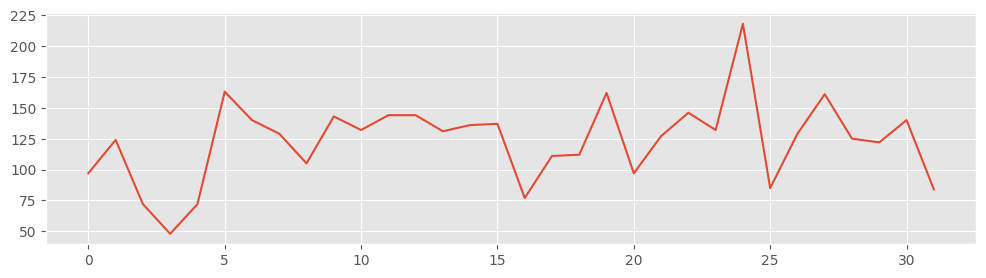

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(dataset[0][0].tolist())
plt.show();

## 4.0 Model

<h3>Architecture Specifications</h3>
The model follows the architecture used in Llama series of models. Its main features are:<br>
<ol>
<li><a href = "https://arxiv.org/pdf/2104.09864v5"> <u>Rotary Positional Embeddings</u></li>
<li><a href = "https://arxiv.org/pdf/2002.05202v1"> <u>Swish Gated Linear unit</u></li>
<li><a href = "https://arxiv.org/pdf/2305.13245v3"> <u>Grouped Quey Attention</u></li>
<li><a href = "https://arxiv.org/pdf/1910.07467"> <u><s>Root Mean Square Normalisation</s></u></li>
</ol>



In our model we use Layer Norm, since the computational benifit for our small model is negligible using RMS Norm. Also accuracy is of more importance, since our model is not large.

### 4.1 SwiGLU

In [21]:
class SwiGLU(nn.Module):
    """
    swiglu = swish(B(W1x+b1)) * (W2x+b2) -> (W1x+b1) * sigmoid(B*(W1x+b1)) * (W2x+b2)
    """
    def __init__(self, dim, beta=1) -> None:
        super(SwiGLU, self).__init__()
        self.linear_gate = nn.Linear(dim, dim)
        self.linear = nn.Linear(dim, dim)
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * F.sigmoid(self.beta*self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

### 4.2 RotaryPositionalEmbedding

In [22]:
class RotaryPositionalEmbeddings(nn.Module):
    def __init__(self, dim, base:float=10000):
        super(RotaryPositionalEmbeddings, self).__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

        self.dim, self.base = dim, base

    def forward(self, x):
        seq_len = x.shape[1]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
            # outer product -> seq_len, dim
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.repeat_interleave(freqs, 2, -1)
            # cos, sin -> 1, 1, seq_len, dim
            self.cos_cached = emb.cos().unsqueeze(0).unsqueeze(1)
            self.sin_cached = emb.sin().unsqueeze(0).unsqueeze(1)
        return self.cos_cached, self.sin_cached

    def extra_repr(self) -> str:
        return f'in_dimension={self.dim}, base_multiplier={self.base}'

def rotate_half(x):
    hdim = x.shape[-1]
    x1, x2 = x[..., : hdim // 2], x[..., hdim // 2 :]
    return torch.cat((-x2, x1), dim=-1)


@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

### 4.3 RoPE Multi-Head Attention

In [23]:
class RoPEMultiHeadAttention(nn.Module):
    def __init__(self, seq_len:int, d_model:int, head_dim:int, num_q_heads:int, num_kv_heads:int, dropout:float, rope_beta:float, use_flash_attn:bool=True):
        super(RoPEMultiHeadAttention, self).__init__()
        assert head_dim == d_model // num_q_heads
        self.query = nn.Linear(d_model , head_dim * num_q_heads)
        self.key = nn.Linear(d_model, head_dim * num_kv_heads)
        self.value = nn.Linear(d_model, head_dim * num_kv_heads)

        self.R = RotaryPositionalEmbeddings(head_dim, rope_beta)
        # for debugging attention, mannual implementation
        if use_flash_attn is False:
            causal_mask = torch.tril(torch.ones(seq_len, seq_len).view(1,1,seq_len, seq_len))
            self.register_buffer('causal_mask', causal_mask)
            self.drop = nn.Dropout(dropout)

        self.head_dim = head_dim
        self.num_q_heads = num_q_heads
        self.num_kv_heads = num_kv_heads
        self.num_q_per_kv = num_q_heads // num_kv_heads
        self.dropout = dropout
        self.use_flash_attn = use_flash_attn

    def forward(self, x):
        batch, seq_len, d_model = x.shape
        # q -> batch, seq_len, hdim * q_heads
        # k, v -> batch, seq_len, hdim * kv_heads
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        # for seperating heads for indivual head-attention calculation
        # q -> batch, seq_len, num_q_heads, head_dim
        # k,v -> batch, seq_len, num_kv_heads, head_dim
        # transposing head numbers and sequence length dimension for dot product attention later
        q = q.view(batch, seq_len, self.num_q_heads, self.head_dim).transpose(1,2)
        k = k.view(batch, seq_len, self.num_kv_heads, self.head_dim).transpose(1,2)
        v = v.view(batch, seq_len, self.num_kv_heads, self.head_dim).transpose(1,2)
        # Grouped Query Attention, ,ight be useful.
        if self.num_q_heads != self.num_kv_heads:
            k = torch.repeat_interleave(k, repeats=self.num_q_per_kv, dim = 1)
            v = torch.repeat_interleave(v, repeats=self.num_q_per_kv, dim = 1)

        # applying rotary positional embedding
        cos, sin = self.R(x)
        qr, kr = apply_rotary_pos_emb(q, k, cos, sin)
        if self.use_flash_attn is False:
            # qr @ kr -> batch, num_kv_heads, seq_len, head_dim @ batch, num_kv_heads, head_dim, seq_len
            # attn_score -> batch, num_q_head, seq_len, seq_len
            attn_scores = qr @ kr.transpose(-2,-1) * torch.rsqrt(torch.tensor(self.head_dim))
            # # Mask  future tokens
            masked_scores = torch.masked_fill(attn_scores, self.causal_mask[:,:,:seq_len,:seq_len] == 0, float('-inf'))
            # # normalise attention_scores
            attn_weights = F.softmax(masked_scores, dim=-1)
            attn_weights = self.drop(attn_weights)
            # attn_out-> batch, num_q_heads, seq_len, head_dim
            attn_out = attn_weights @ v
        else:
            # attn_out-> batch, num_q_heads, seq_len, head_dim
            attn_out = F.scaled_dot_product_attention(qr, kr, v, dropout_p=self.dropout, is_causal=True)
        # batch, seq_len, d_model
        attn_out = attn_out.transpose(1,2).contiguous().view(batch, seq_len, d_model)
        return attn_out

### 4.4 Model Block

In [24]:
class RoPEModelBlock(nn.Module):
    def __init__(self, seq_len:int, d_model:int, head_dim:int, num_q_heads:int, num_kv_heads:int, dropout:float, rope_beta:float, proj_fac:int=4, use_flash_attn:bool=True):
        super(RoPEModelBlock, self).__init__()
        self.pre_ln = nn.LayerNorm(d_model)
        self.rmha = RoPEMultiHeadAttention(seq_len, d_model, head_dim, num_q_heads, num_kv_heads, dropout, rope_beta, use_flash_attn)
        self.up_proj = nn.Linear(d_model, d_model * proj_fac)
        self.swiglu = SwiGLU(d_model*proj_fac)
        self.down_proj = nn.Linear(d_model * proj_fac, d_model)
        self.post_ln = nn.LayerNorm(d_model)

    def forward(self, x):
        skip = x
        x = self.pre_ln(x)
        x = skip + self.rmha(x)
        skip = x
        x = self.post_ln(x)
        x = self.down_proj(self.swiglu(self.up_proj(x)))
        x += skip
        return x

### 4.5 Complete Model

In [25]:
class Model(nn.Module):
    def __init__(self, vocab:int, seq_len:int, d_model:int, num_q_heads:int, num_kv_heads:int, dropout:float, num_layers:int, rope_beta:float, proj_fac:int, use_flash_attn:bool=True, initialise:bool=False):
        super(Model, self).__init__()
        head_dim = d_model // num_q_heads
        self.Embedding_layer = nn.Embedding(vocab, d_model)
        self.RoPE_Attention = nn.Sequential(*[RoPEModelBlock(seq_len, d_model, head_dim, num_q_heads, num_kv_heads, dropout, rope_beta, proj_fac, use_flash_attn) for _ in range(num_layers)])
        self.Out_layer = nn.Linear(d_model, vocab)
        self.Out_layer.weight = self.Embedding_layer.weight


        self.vocab = vocab
        self.seq_len = seq_len
        self.d_model = d_model
        self.head_dim = head_dim
        self.num_q_heads = num_q_heads
        self.num_kv_heads = num_kv_heads
        self.dropout = dropout
        self.num_layers = num_layers
        self.proj_fac = proj_fac
        if initialise is True:
            self.init_weights()

    def forward(self, x):
        # x -> batch, seq_len
        # embedings -> batch, seq_len, d_model
        emb = self.Embedding_layer(x)
        # attn_out -> batch, seq_len, d_model
        attn_out = self.RoPE_Attention(emb)
        # logits -> batch, seq_len, vocab_size
        logits = self.Out_layer(attn_out)
        return logits

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)

In [26]:
class WarmupScheduler:
    def __init__(self, optimizer, min_lr:float, max_lr:float, smoothing_factor:float, warmup_steps:int|None=None, restart_steps:int|None=None):
        self.optimizer = optimizer
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.restart_steps = restart_steps
        self.smoothing_factor = smoothing_factor
        self._step = 0
        self._current_lr = self.optimizer.param_groups[0]['lr']
        self._init_lr = self._current_lr


    def state_dict(self):
        return {key:value for key,value in self.__dict__.items() if key!= 'optimizer'}

    def load_state_dict(self, state_dict):
        self.__dict__.update(state_dict)

    def set_warmup_restart_steps(self, warmup_steps, restart_steps):
        self.warmup_steps = warmup_steps
        self.restart_steps = restart_steps

    def step(self):
        assert self.warmup_steps and self.restart_steps is not None, 'Initialise warump steps with set_warmup_restart_steps function'


        if self._step >= self.restart_steps:
            self._step = 0
            self._current_lr = self._init_lr
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._current_lr = rate

    def rate(self):
        assert self.warmup_steps and self.restart_steps is not None, 'Initialise warump steps with set_warmup_restart_steps function'
        if self._step <= self.warmup_steps:
            rate = self._step / self.warmup_steps * self.max_lr
        else:
            # (1-self._step/ self.restart_steps) -> decreasnig, raised by smoothing factor to higher polynomial,
            # min lr is added to keep it above it
            rate = (1 - (self._step / self.restart_steps)**self.smoothing_factor) * self._current_lr + self.min_lr

        if rate < self.min_lr:
                rate = self.min_lr
        if rate > self.max_lr:
            rate = self.max_lr
        return rate

    def get_last_lr(self):
        return self._current_lr

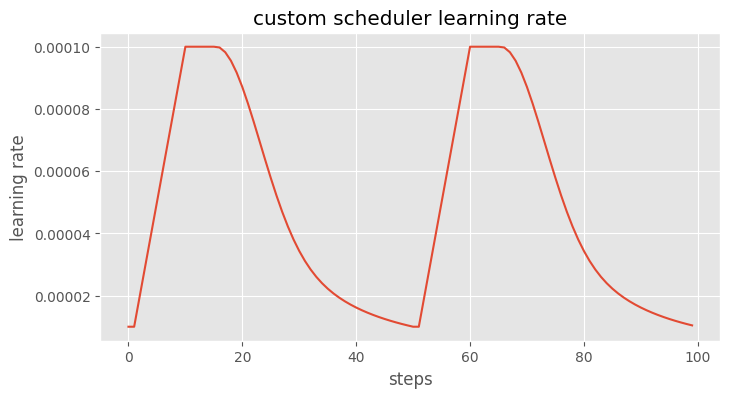

In [27]:
def test():

    model = torch.nn.Sequential(
        torch.nn.Linear(4, 10)
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    scheduler = WarmupScheduler(optimizer, min_lr=1e-5, max_lr=1e-4, smoothing_factor=2)
    scheduler.set_warmup_restart_steps(100*0.1, 100*0.5)
    lrs = []
    for i in range(0, 100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    plt.figure(figsize=(8,4))
    plt.plot(lrs)
    plt.title('custom scheduler learning rate')
    plt.xlabel('steps')
    plt.ylabel('learning rate')
    plt.show()

test()

## 5.0 Trainer

In [28]:
def save_checkpoint(model, optimizer, scheduler, model_save_path:str) -> None:
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    },model_save_path)

def load_checkpoint(model, optimizer, scheduler,model_load_path:str):
    device = next(model.parameters()).device
    checkpoint = torch.load(model_load_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return model, optimizer, scheduler

In [29]:
torch.cuda.is_bf16_supported(including_emulation=False)

False

In [30]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        dataset,
        batch_size: int,
        epochs: int,
        model_save_path: str,
        model_load_path: str,
        use_amp: bool=False,
        train_val_split: tuple[float, float] = (0.8, 0.2)
        ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.model_save_path = model_save_path
        self.model_load_path = model_load_path
        self.device = next(model.parameters()).device

        self.use_amp = use_amp
        self.train_val_split = train_val_split

    def get_dataloaders(self, split) -> DataLoader:
        train_dataset, val_dataset = random_split(self.dataset, self.train_val_split)
        if split == 'train':
            loader = DataLoader(train_dataset, self.batch_size, shuffle=True)
        elif split == 'val':
            loader = DataLoader(val_dataset, self.batch_size, shuffle=False)
        return loader

    def evaluate_accuracy(self, logits:torch.Tensor, real_labels:torch.Tensor)->torch.Tensor:
        with torch.no_grad():
            log_probs = F.softmax(logits, dim=-1)
            pred_label = torch.argmax(log_probs, dim=-1)
        return torch.mean((pred_label == real_labels).float()).item()

    def train_model_with_amp(self):
        """Train with mixed precision."""
        train_loader = self.get_dataloaders('train')
        loss_dict = {'loss': [], 'acc': []}
        self.model.train()
        loader = tqdm(train_loader, leave=True)
        scaler = torch.amp.GradScaler()

        self.scheduler.set_warmup_restart_steps(warmup_steps = int(len(train_loader)*0.1), restart_steps = len(train_loader))

        for i, (x,y) in enumerate(loader):
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()

            if torch.cuda.is_bf16_supported(including_emulation=False) is False:
                dtype = torch.float16
            else:
                dtype = torch.bfloat16
            with torch.autocast(device_type=str(self.device), dtype=dtype):
                y_pred = self.model(x)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))

            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            self.scheduler.step()
            accuracy = self.evaluate_accuracy(y_pred, y)
            loss_dict['loss'].append(loss.cpu().item())
            loss_dict['acc'].append(accuracy)
            if self.epochs <= 10:
                if i % (len(train_loader) // 5) == 0:
                    gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                    print(f'\nTrain Loss : {loss:.4f} | Train Accuracy : {accuracy:.4f} | gpu usage: {gpu_usage}')
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])

    def train_model(self):
        train_loader = self.get_dataloaders('train')
        loss_dict = {'loss': [], 'acc': []}
        loader = tqdm(train_loader, leave=True)
        self.model.train()

        self.scheduler.set_warmup_restart_steps(warmup_steps = int(len(train_loader)*0.1), restart_steps = len(train_loader))

        for i, (x, y) in  enumerate(loader):
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
            accuracy = self.evaluate_accuracy(y_pred, y)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            loss_dict['loss'].append(loss.cpu().item())
            loss_dict['acc'].append(accuracy)
            if self.epochs <= 10:
                if i % (len(train_loader) // 5) == 0:
                    gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                    print(f'\nTrain Loss : {loss:.4f} | Train Accuracy : {accuracy:.4f} | GPU Usage: {gpu_usage}')
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])

    def eval_model(self):
        val_loader = self.get_dataloaders('val')
        loss_dict = {'loss': [], 'acc': []}
        for x, y in val_loader:
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                self.model.eval()
                y_pred = self.model(x)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
                accuracy = self.evaluate_accuracy(y_pred, y)
                loss_dict['loss'].append(loss.cpu().item())
                loss_dict['acc'].append(accuracy)
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])

    def train(self):
        if self.model_load_path is not None:
            self.model, self.optimizer, self.scheduler = load_checkpoint(self.model, self.optimizer, self.scheduler, self.model_load_path)
        try:
            loader = tqdm(range(self.epochs), leave=True)
            for epoch in loader:
                if self.use_amp is True:
                    train_loss, train_acc = self.train_model_with_amp()
                else:
                    train_loss, train_acc = self.train_model()
                val_loss, val_acc = self.eval_model()

                if epoch % (self.epochs / 10) == 0:
                    gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                    print(f'\nEpochs: {epoch} | Train_loss : {train_loss:.4f} | val_loss: {val_loss:.4f}',
                          f'| train_acc : {train_acc:.4f} | val_acc : {val_acc:.4f} | GPU usage : {gpu_usage}\n',
                          )
        except KeyboardInterrupt:
            save_checkpoint(self.model, self.optimizer, self.scheduler, self.model_save_path)
        save_checkpoint(self.model, self.optimizer, self.scheduler, self.model_save_path)

## 6.0 Loading Model

In [113]:
@dataclass
class mconfig:
    vocab_size = 128
    seq_len = 32
    embed_dim = 128
    num_q_heads = 4
    num_kv_heads = 4
    rope_beta = 1e4
    dropout = 0.3
    num_layers = 2
    proj_fac = 4
    use_flash_attn = True
    initialise_parmas = False

In [114]:
@dataclass
class tconfig:
    features = ['Close']
    batch_size = 4096
    epochs = 10
    min_lr = 1e-4
    max_lr = 1e-3
    smoothing_factor = 2
    model_save_path = r'/content/model_small.pt'
    model_load_path = model_save_path

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    use_amp = True
    train_path = r'/content/Indian_stocks'
    test_path = r'/content/Indian_stocks/ZEEL.csv'

In [115]:
model = Model(mconfig.vocab_size,  mconfig.seq_len, mconfig.embed_dim, mconfig.num_q_heads, mconfig.num_kv_heads,
              mconfig.dropout, mconfig.num_layers, mconfig.rope_beta, mconfig.proj_fac, mconfig.use_flash_attn, mconfig.initialise_parmas)
model.to(tconfig.device)

Model(
  (Embedding_layer): Embedding(128, 128)
  (RoPE_Attention): Sequential(
    (0): RoPEModelBlock(
      (pre_ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (rmha): RoPEMultiHeadAttention(
        (query): Linear(in_features=128, out_features=128, bias=True)
        (key): Linear(in_features=128, out_features=128, bias=True)
        (value): Linear(in_features=128, out_features=128, bias=True)
        (R): RotaryPositionalEmbeddings(in_dimension=32, base_multiplier=10000.0)
      )
      (up_proj): Linear(in_features=128, out_features=512, bias=True)
      (swiglu): SwiGLU(
        (linear_gate): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (down_proj): Linear(in_features=512, out_features=128, bias=True)
      (post_ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): RoPEModelBlock(
      (pre_ln): LayerNorm((128,), eps=1e-05, elementwise_affine=Tr

In [116]:
print(f'Number of parameters in model: {sum(i.numel() for i in model.parameters()):.2e}')

Number of parameters in model: 1.43e+06


## 7.0 Training

In [117]:
loader = CSVLoader(tconfig.train_path, ['Close'], split=0.9)
data = loader.get_data_from_csv_files()
preprocessor = Preprocessor(mconfig.vocab_size-1, drop_p=99.5)
dataset = CSVDataset(data, mconfig.seq_len, preprocessor)

In [118]:
optimizer = torch.optim.AdamW(model.parameters(), tconfig.min_lr)
scheduler = WarmupScheduler(optimizer, tconfig.min_lr, tconfig.max_lr, tconfig.smoothing_factor)

In [119]:
trainer = Trainer(model, optimizer, scheduler, dataset, tconfig.batch_size, tconfig.epochs, tconfig.model_save_path, tconfig.model_load_path, use_amp = tconfig.use_amp).train()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8539 | Train Accuracy : 0.0555 | gpu usage: 5.9

Train Loss : 3.8616 | Train Accuracy : 0.0536 | gpu usage: 5.9

Train Loss : 3.8560 | Train Accuracy : 0.0550 | gpu usage: 5.9

Train Loss : 3.8518 | Train Accuracy : 0.0546 | gpu usage: 5.9

Train Loss : 3.8575 | Train Accuracy : 0.0563 | gpu usage: 5.9

Train Loss : 3.8583 | Train Accuracy : 0.0564 | gpu usage: 5.9

Epochs: 0 | Train_loss : 3.8539 | val_loss: 3.8488 | train_acc : 0.0552 | val_acc : 0.0567 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8491 | Train Accuracy : 0.0569 | gpu usage: 5.9

Train Loss : 3.8493 | Train Accuracy : 0.0546 | gpu usage: 5.9

Train Loss : 3.8594 | Train Accuracy : 0.0548 | gpu usage: 5.9

Train Loss : 3.8382 | Train Accuracy : 0.0574 | gpu usage: 5.9

Train Loss : 3.8477 | Train Accuracy : 0.0580 | gpu usage: 5.9

Train Loss : 3.8428 | Train Accuracy : 0.0573 | gpu usage: 5.9

Epochs: 1 | Train_loss : 3.8502 | val_loss: 3.8446 | train_acc : 0.0560 | val_acc : 0.0575 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8477 | Train Accuracy : 0.0580 | gpu usage: 5.9

Train Loss : 3.8488 | Train Accuracy : 0.0570 | gpu usage: 5.9

Train Loss : 3.8535 | Train Accuracy : 0.0560 | gpu usage: 5.9

Train Loss : 3.8463 | Train Accuracy : 0.0571 | gpu usage: 5.9

Train Loss : 3.8361 | Train Accuracy : 0.0581 | gpu usage: 5.9

Train Loss : 3.8432 | Train Accuracy : 0.0586 | gpu usage: 5.9

Epochs: 2 | Train_loss : 3.8463 | val_loss: 3.8422 | train_acc : 0.0568 | val_acc : 0.0582 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8351 | Train Accuracy : 0.0581 | gpu usage: 5.9

Train Loss : 3.8465 | Train Accuracy : 0.0568 | gpu usage: 5.9

Train Loss : 3.8439 | Train Accuracy : 0.0569 | gpu usage: 5.9

Train Loss : 3.8343 | Train Accuracy : 0.0584 | gpu usage: 5.9

Train Loss : 3.8318 | Train Accuracy : 0.0597 | gpu usage: 5.9

Train Loss : 3.8291 | Train Accuracy : 0.0592 | gpu usage: 5.9

Epochs: 3 | Train_loss : 3.8422 | val_loss: 3.8366 | train_acc : 0.0577 | val_acc : 0.0591 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8462 | Train Accuracy : 0.0590 | gpu usage: 5.9

Train Loss : 3.8478 | Train Accuracy : 0.0576 | gpu usage: 5.9

Train Loss : 3.8418 | Train Accuracy : 0.0582 | gpu usage: 5.9

Train Loss : 3.8333 | Train Accuracy : 0.0600 | gpu usage: 5.9

Train Loss : 3.8273 | Train Accuracy : 0.0600 | gpu usage: 5.9

Train Loss : 3.8358 | Train Accuracy : 0.0578 | gpu usage: 5.9

Epochs: 4 | Train_loss : 3.8375 | val_loss: 3.8318 | train_acc : 0.0584 | val_acc : 0.0599 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8321 | Train Accuracy : 0.0610 | gpu usage: 5.9

Train Loss : 3.8387 | Train Accuracy : 0.0582 | gpu usage: 5.9

Train Loss : 3.8278 | Train Accuracy : 0.0587 | gpu usage: 5.9

Train Loss : 3.8264 | Train Accuracy : 0.0601 | gpu usage: 5.9

Train Loss : 3.8282 | Train Accuracy : 0.0598 | gpu usage: 5.9

Train Loss : 3.8240 | Train Accuracy : 0.0611 | gpu usage: 5.9

Epochs: 5 | Train_loss : 3.8334 | val_loss: 3.8243 | train_acc : 0.0593 | val_acc : 0.0615 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8296 | Train Accuracy : 0.0606 | gpu usage: 5.9

Train Loss : 3.8321 | Train Accuracy : 0.0593 | gpu usage: 5.9

Train Loss : 3.8274 | Train Accuracy : 0.0610 | gpu usage: 5.9

Train Loss : 3.8289 | Train Accuracy : 0.0605 | gpu usage: 5.9

Train Loss : 3.8225 | Train Accuracy : 0.0618 | gpu usage: 5.9

Train Loss : 3.8200 | Train Accuracy : 0.0620 | gpu usage: 5.9

Epochs: 6 | Train_loss : 3.8269 | val_loss: 3.8191 | train_acc : 0.0606 | val_acc : 0.0625 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8204 | Train Accuracy : 0.0630 | gpu usage: 5.9

Train Loss : 3.8328 | Train Accuracy : 0.0596 | gpu usage: 5.9

Train Loss : 3.8315 | Train Accuracy : 0.0595 | gpu usage: 5.9

Train Loss : 3.8232 | Train Accuracy : 0.0628 | gpu usage: 5.9

Train Loss : 3.8133 | Train Accuracy : 0.0638 | gpu usage: 5.9

Train Loss : 3.8127 | Train Accuracy : 0.0642 | gpu usage: 5.9

Epochs: 7 | Train_loss : 3.8215 | val_loss: 3.8124 | train_acc : 0.0618 | val_acc : 0.0637 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8174 | Train Accuracy : 0.0634 | gpu usage: 5.9

Train Loss : 3.8269 | Train Accuracy : 0.0611 | gpu usage: 5.9

Train Loss : 3.8267 | Train Accuracy : 0.0606 | gpu usage: 5.9

Train Loss : 3.8185 | Train Accuracy : 0.0629 | gpu usage: 5.9

Train Loss : 3.7962 | Train Accuracy : 0.0650 | gpu usage: 5.9

Train Loss : 3.8104 | Train Accuracy : 0.0651 | gpu usage: 5.9

Epochs: 8 | Train_loss : 3.8143 | val_loss: 3.8032 | train_acc : 0.0631 | val_acc : 0.0653 | GPU usage : 5.9



  0%|          | 0/87 [00:00<?, ?it/s]


Train Loss : 3.8039 | Train Accuracy : 0.0639 | gpu usage: 5.9

Train Loss : 3.8168 | Train Accuracy : 0.0625 | gpu usage: 5.9

Train Loss : 3.8685 | Train Accuracy : 0.0545 | gpu usage: 5.9

Train Loss : 3.8137 | Train Accuracy : 0.0629 | gpu usage: 5.9

Train Loss : 3.7974 | Train Accuracy : 0.0655 | gpu usage: 5.9

Train Loss : 3.8012 | Train Accuracy : 0.0659 | gpu usage: 5.9

Epochs: 9 | Train_loss : 3.8283 | val_loss: 3.8012 | train_acc : 0.0614 | val_acc : 0.0657 | GPU usage : 5.9



In [122]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [123]:
!cp '/content/model_small.pt' '/content/drive/MyDrive/Models/ts_small.pt'

## 8.0 Inference

In [124]:
def get_data(path, feature):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    data = df[feature].to_numpy(np.float64)
    return data, df['Date']

test_data, date = get_data(tconfig.test_path, ['Close'])
print(f'Shape test data: {test_data.shape}')

Shape test data: (5306, 1)


In [125]:
model, _, _ = load_checkpoint(model, optimizer, scheduler, tconfig.model_save_path)

RMSE for generation: 34.912185957629895
RMSE for random walk: 55.277700661465715 


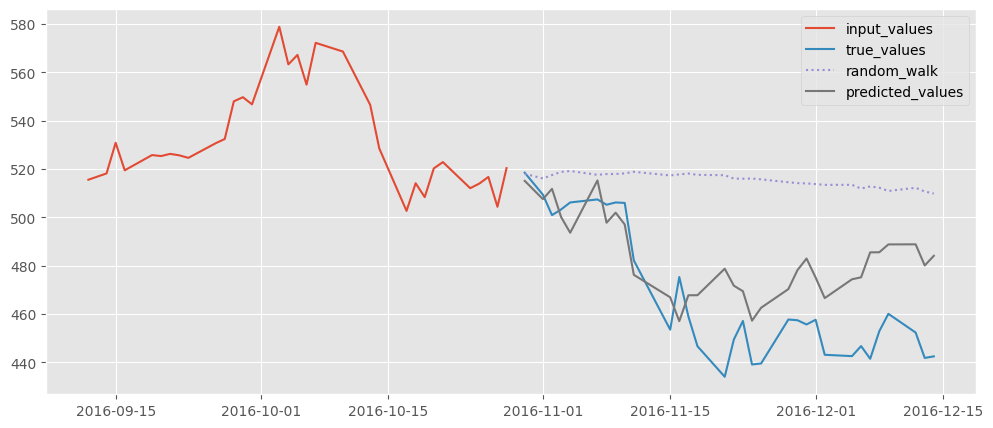

In [126]:
class CustomInference:
    def __init__(
        self,
        model,
        data: np.ndarray,
        preprocessor,
        gen_len: Optional[int]=None,
        top_k : int = 50,
        temperature: float = 1.0,
        randomizer=True
        ):
        self.model = model
        self.data = data
        self.preprocessor = preprocessor
        self.gen_len = gen_len
        self.top_k = top_k
        self.temperature = temperature

        self.seq_len = model.seq_len
        self.device = next(model.parameters()).device

        if self.gen_len is None:
            self.gen_len = self.seq_len

        if randomizer is True:
            self.idx = np.random.randint(0, self.data.shape[0] - self.seq_len - self.gen_len - 1)

        if top_k > model.vocab:
            raise ValueError(f'Value of top_k should be less than vocab size of model.')

        if len(data) <= self.seq_len + self.gen_len:
            raise Exception('Data provided cannot be splitted into input and true values.')

    def top_k_pipline(self, token_ids:torch.Tensor)->np.ndarray:
        if token_ids.ndim == 1:
            token_ids = token_ids.unsqueeze(0)
        self.model.eval()
        with torch.inference_mode():
            for _ in range(self.gen_len):
                # pick last seq_len tokens
                x_trunc = token_ids[:, -self.seq_len:]
                # batch, seq_len -> batch, seq_len, vocab_size
                logits = self.model(x_trunc)
                # Pick last token as model is conditioned with sliding window at training,
                # Take softmax on unnormalised output and divide by scaling factor to make probablities peaky or uniform.
                # batch, seq_len, vocab_size -> batch, vocab_size
                probs = F.softmax(logits[:,-1,:]/self.temperature, dim=-1)
                # find top-k probabilites with there indices, indices are only relevant as we are concerned with token ids
                # rather than the probability values of token_ids
                topk_probs, topk_idx = torch.topk(probs, self.top_k)
                # Sample from multinomial distribution
                ix = torch.multinomial(topk_probs, num_samples=1)
                # check documentation, picks values corresponding to indices (token_ids) and arange the in order.
                next_tok = torch.gather(topk_idx,-1,ix)
                # Concatenate New token generation : batch, seq_len -> batch, seq_len + gen_len
                token_ids = torch.cat((x_trunc,next_tok),dim=1)
        # Flatten : batch, seq_len -> batch x seq_len
        return token_ids[:,-self.gen_len:].view(-1).cpu().numpy()

    def run_random_walk(self):
        rand_walk = np.zeros(self.gen_len)
        noise = np.random.randn(self.gen_len)
        rand_walk += noise
        rand_walk = np.concatenate((self.data[self.idx + self.seq_len], rand_walk), axis=0)

        drift = np.arange(-1.0, 1.0, 0.1)
        drift = np.random.choice(drift)
        rand_walk = np.cumsum(rand_walk  + drift)
        return rand_walk[1:]

    def predict(self):

        detrended_data = self.preprocessor.fit(data)

        input_ = detrended_data[self.idx : self.idx + self.seq_len]
        token_ids = self.preprocessor.transform(input_)

        token_ids = torch.tensor(token_ids, device=self.device)

        out = self.top_k_pipline(token_ids)
        preds = self.preprocessor.inverse_transform(out, self.data[self.idx + self.seq_len])
        return preds[1:]

    def compute_rmse(self, y_preds, y):
        return np.sqrt(np.mean((y_preds - y)**2))


    def visualise(self, **date):
        input_ = self.data[self.idx : self.idx + self.seq_len]
        true_ = self.data[self.idx + self.seq_len : self.idx + self.seq_len + self.gen_len]
        preds = self.predict()
        random_walk = self.run_random_walk()

        error = np.sqrt(np.mean((preds - true_)**2))
        error_ = np.sqrt(np.mean(((random_walk - true_)**2)))
        print(f'RMSE for generation: {error}\nRMSE for random walk: {error_} ')

        date = date.get('date', None)
        if date is not None:
            date = date[self.idx : self.idx + self.seq_len + self.gen_len]
        if date is None:
            date = np.arange(0, self.seq_len + self.gen_len)

        plt.figure(figsize=(12,5))
        plt.plot(date[:self.seq_len], input_, label='input_values')
        plt.plot(date[self.seq_len:], true_, label='true_values')
        plt.plot(date[self.seq_len :], random_walk, label='random_walk', linestyle=':')
        plt.plot(date[self.seq_len:],preds, label='predicted_values')
        plt.legend()
        plt.show();

    def test_model(self, n_steps):
        acc_dict = {'pred_acc':[], 'rand_acc':[]}
        for _ in tqdm(range(n_steps)):
            idx = np.random.randint(0, self.data.shape[0] - self.seq_len - self.gen_len)
            true_ = self.data[idx + self.seq_len : idx + self.seq_len + self.gen_len]
            preds = self.predict()
            random_walk = self.run_random_walk()
            acc_dict['pred_acc'].append(self.compute_rmse(preds, true_))
            acc_dict['rand_acc'].append(self.compute_rmse(random_walk, true_))
        return np.mean(acc_dict['pred_acc']), np.mean(acc_dict['rand_acc'])
pipeline = CustomInference(model, test_data, preprocessor, 32, 50, 1.0)

pipeline.visualise(date=date)

In [127]:
n_steps = 100
preds_avg_rmse, randwalk_avg_rmse = pipeline.test_model(n_steps)
print(f'Over {n_steps} steps:\nAverage RMSE from predictions : {preds_avg_rmse}',
      f'\nAverage RMSE for random walk : {randwalk_avg_rmse}')

  0%|          | 0/100 [00:00<?, ?it/s]

Over 100 steps:
Average RMSE from predictions : 265.63172524546275 
Average RMSE for random walk : 262.4135720985648
